In [1]:
import sys
import os

import pandas as pd

import ipywidgets as widgets
from IPython.display import display

# add parent directory to path
library_path = os.path.abspath('..')
if library_path not in sys.path:
    sys.path.append(library_path)

from ideal_genom.zoom_heatmap import  draw_zoomed_heatmap

In [2]:
# Create interactive widgets for input
input_path = widgets.Text(
    value='/home/luis/data/gwasResult/',
    description='Path to project folder:',
    style={'description_width': 'initial'}
)

input_name = widgets.Text(
    value='annotated_normalized_combined_R2_0.3.dose_step2_sex_pheno-glm.PHENO1.glm.logistic.hybrid',
    description='Name of GWAS summary file:',
    style={'description_width': 'initial'}
)

top_snp = widgets.Text(
    value='table_lead_SNPS_GWAS_glm_logistic_final_paper',
    description='Name of file with SNPs to highlight:',
    style={'description_width': 'initial'}
)

bfile_path = widgets.Text(
    value='/home/luis/data/LuxGiantimputed/inputData/',
    description='Path to project folder:',
    style={'description_width': 'initial'}
)

bfile_name = widgets.Text(
    value='luxgiant_imputed_noprobID',
    description='Path to project folder:',
    style={'description_width': 'initial'}
)

# Display the widgets
display(input_path, input_name, top_snp, bfile_path, bfile_name)

# Function to get the text parameter values
def get_params():
    return input_path.value, input_name.value, top_snp.value, bfile_path.value, bfile_name.value

Text(value='/home/luis/data/gwasResult/', description='Path to project folder:', style=TextStyle(description_w…

Text(value='annotated_normalized_combined_R2_0.3.dose_step2_sex_pheno-glm.PHENO1.glm.logistic.hybrid', descrip…

Text(value='table_lead_SNPS_GWAS_glm_logistic_final_paper', description='Name of file with SNPs to highlight:'…

Text(value='/home/luis/data/LuxGiantimputed/inputData/', description='Path to project folder:', style=TextStyl…

Text(value='luxgiant_imputed_noprobID', description='Path to project folder:', style=TextStyle(description_wid…

In [3]:
# Use the parameter values
path_params = get_params()
print(f"Parameter 1: {path_params[0]}")
print(f"Parameter 2: {path_params[1]}")
print(f"Parameter 3: {path_params[2]}")
print(f"Parameter 4: {path_params[3]}")
print(f"Parameter 5: {path_params[4]}")

Parameter 1: /home/luis/data/gwasResult/
Parameter 2: annotated_normalized_combined_R2_0.3.dose_step2_sex_pheno-glm.PHENO1.glm.logistic.hybrid
Parameter 3: table_lead_SNPS_GWAS_glm_logistic_final_paper
Parameter 4: /home/luis/data/LuxGiantimputed/inputData/
Parameter 5: luxgiant_imputed_noprobID


In [4]:
cols_touse = widgets.Textarea(
    value="#CHROM, POS, ID, P",
    description='Columns to use on the Mannhattan plot (comma-separated):',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)
display(cols_touse)

def get_cols():
    return cols_touse.value

Textarea(value='#CHROM, POS, ID, P', description='Columns to use on the Mannhattan plot (comma-separated):', l…

In [5]:
cols = get_cols()

df_gwas = pd.read_csv(
    os.path.join(path_params[0], path_params[1]), sep='\t', usecols=[col.strip() for col in cols.split(',')]
)
df_gwas.head(5)

,#CHROM,POS,ID,P
0,1,727242,rs61769339,0.355696
1,1,727717,rs61769340,0.517232
2,1,730869,rs200188737,0.510707
3,1,732369,rs1315713498,0.741994
4,1,740738,rs146067153,0.816063


In [6]:
rsID = widgets.Text(
    value='SNP',
    description='Column name with the rsID:',
    style={'description_width': 'initial'}
)

display(rsID)

def get_rsID():
    return rsID.value

Text(value='SNP', description='Column name with the rsID:', style=TextStyle(description_width='initial'))

In [7]:
gwas_rsID = get_rsID()

if path_params[2] is not None or path_params[2] != '':
    highlit_path = os.path.join(path_params[0], path_params[2])
    if os.path.exists(highlit_path):
        df_high = pd.read_csv(
            highlit_path, sep='\t'
        )
        to_highlight = df_high[gwas_rsID].to_list()
        print(to_highlight[:10])
        del df_high
    else:
        print('Path to file with SNPs to highlight does not exist')
        to_highlight = []
else:
    print('No file with SNPs to highlight')
    to_highlight = []

['rs3747973', 'rs74990530', 'rs34311866', 'rs356182', 'rs7681440', 'rs1846190', 'rs2517680', 'rs4909940', 'rs528813377', 'rs56328224']


In [8]:
SNP_col = widgets.Text(
    value='ID',
    description='Column with rsID:',
    style={'description_width': 'initial'}
)

CHR_col = widgets.Text(
    value='#CHROM',
    description='Column with chromosome:',
    style={'description_width': 'initial'}
)

POS_col = widgets.Text(
    value='POS',
    description='Column with base-pair position:',
    style={'description_width': 'initial'}
)

P_col = widgets.Text(
    value='P',
    description='Column with p-values:',
    style={'description_width': 'initial'}
)

display(SNP_col, CHR_col, POS_col, P_col)

def get_col_names():
    return SNP_col.value, CHR_col.value, POS_col.value, P_col.value,

Text(value='ID', description='Column with rsID:', style=TextStyle(description_width='initial'))

Text(value='#CHROM', description='Column with chromosome:', style=TextStyle(description_width='initial'))

Text(value='POS', description='Column with base-pair position:', style=TextStyle(description_width='initial'))

Text(value='P', description='Column with p-values:', style=TextStyle(description_width='initial'))

In [9]:
snp_col, chr_col, pos_col, p_col = get_col_names()

In [10]:
radius = widgets.IntText(
    value=1e6,
    description='Radius for the LD calculation:',
    style={'description_width': 'initial'}
)

threshold = widgets.FloatText(
    value=5e-6,
    description='Threshold for the LD calculation:',
    style={'description_width': 'initial'}
)

display(radius, threshold)

def get_values():
    return radius.value, threshold.value

IntText(value=1000000, description='Radius for the LD calculation:', style=DescriptionStyle(description_width=…

FloatText(value=5e-06, description='Threshold for the LD calculation:', style=DescriptionStyle(description_wid…

In [11]:
radius, pval_threshold = get_values()

In [12]:
#draw_zoomed_heatmap(
#    data_df=df_gwas,
#    lead_snp=to_highlight[0], 
#    snp_col=snp_col, 
#    p_col=p_col, 
#    pos_col=pos_col, 
#    chr_col=chr_col, 
#    output_folder=path_params[0], 
#    pval_threshold=5e-6, 
#    radius=radius, 
#    build='38', 
#    gtf_path=None, 
#    batch_size=100, 
#    bfile_folder=path_params[3], 
#    bfile_name=path_params[4], 
#    effect_dict={}    
#)

In [12]:
draw_zoomed_heatmap(
    data_df=df_gwas,
    lead_snp=to_highlight[0], 
    snp_col=snp_col, 
    p_col=p_col, 
    pos_col=pos_col, 
    chr_col=chr_col, 
    output_folder=path_params[0], 
    pval_threshold=5e-6, 
    radius=radius, 
    build='38', 
    gtf_path=None, 
    batch_size=100, 
    bfile_folder=path_params[3], 
    bfile_name=path_params[4], 
    effect_dict={}    
)

2024/12/16 16:03:33 Start to annotate variants with nearest gene name(s)...
2024/12/16 16:03:33  -Assigning Gene name using NCBI refseq latest GRCh38 for protein coding genes
2024/12/16 16:03:33  -Using user-provided gtf:/home/luis/CGE/ideal-genom/GCF_000001405.40_GRCh38.p14_genomic.gtf
2024/12/16 16:03:36 Finished annotating variants with nearest gene name(s) successfully!


KeyboardInterrupt: 

2024/12/16 15:07:46 Start to annotate variants with nearest gene name(s)...
2024/12/16 15:07:46  -Assigning Gene name using NCBI refseq latest GRCh38 for protein coding genes
2024/12/16 15:07:46  -Using user-provided gtf:/home/luis/CGE/ideal-genom/GCF_000001405.40_GRCh38.p14_genomic.gtf
2024/12/16 15:07:46 Finished annotating variants with nearest gene name(s) successfully!


  Functional_Consequence  count
0         intron_variant     37
1  upstream_gene_variant      5
2    5_prime_UTR_variant      3
3     intergenic_variant      3
4       missense_variant      2
5    3_prime_UTR_variant      1
6     synonymous_variant      1




    gene      start        end strand  length  start_esc     end_esc  \
0  ITPKB  226631690  226739282      -  107593  226.63169  226.739282   

   length_esc  
0    0.107592  


PLINK v1.90b7.4 64-bit (18 Aug 2024)           www.cog-genomics.org/plink/1.9/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/luis/da

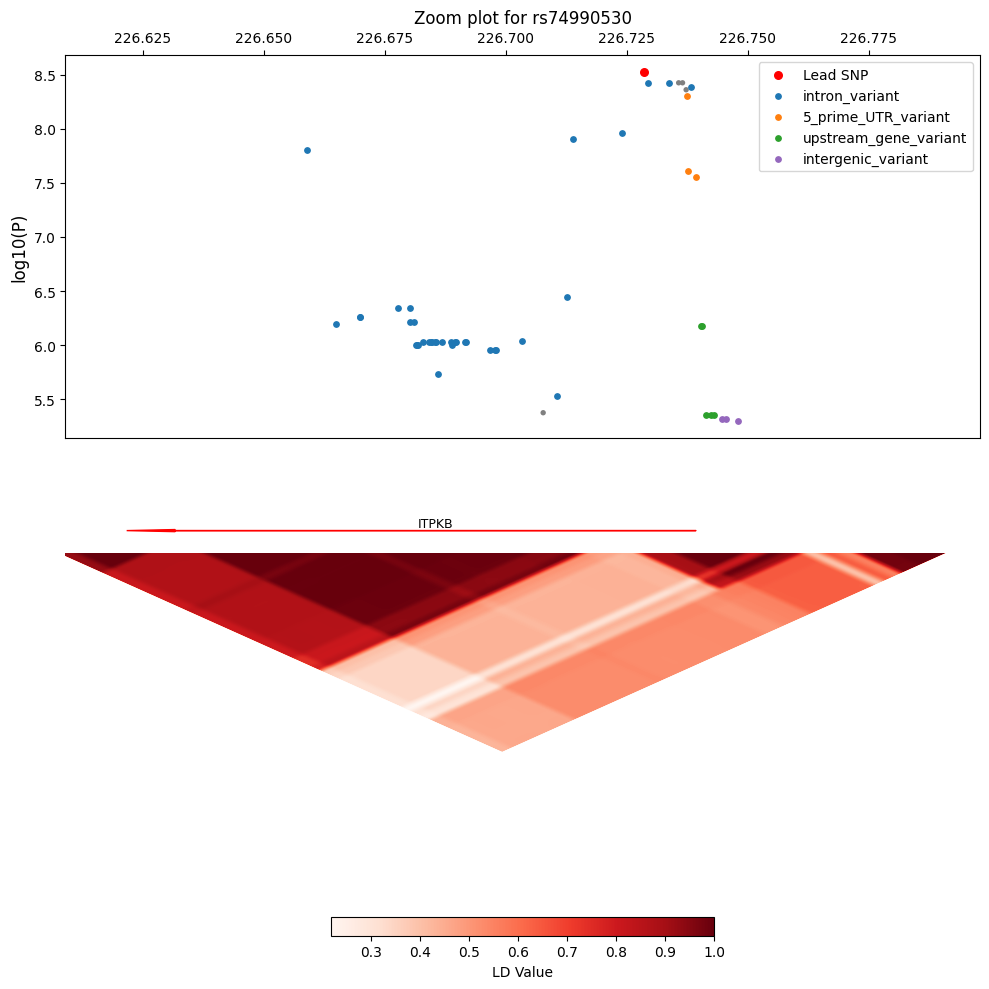

True

In [14]:
draw_zoomed_heatmap(
    data_df=df_gwas,
    lead_snp=to_highlight[1], 
    snp_col=snp_col, 
    p_col=p_col, 
    pos_col=pos_col, 
    chr_col=chr_col, 
    output_folder=path_params[0], 
    pval_threshold=5e-6, 
    radius=radius, 
    build='38', 
    gtf_path=None, 
    batch_size=100, 
    bfile_folder=path_params[3], 
    bfile_name=path_params[4], 
    effect_dict={}    
)

2024/12/16 15:08:09 Start to annotate variants with nearest gene name(s)...
2024/12/16 15:08:09  -Assigning Gene name using NCBI refseq latest GRCh38 for protein coding genes
2024/12/16 15:08:09  -Using user-provided gtf:/home/luis/CGE/ideal-genom/GCF_000001405.40_GRCh38.p14_genomic.gtf
2024/12/16 15:08:09 Finished annotating variants with nearest gene name(s) successfully!


                Functional_Consequence  count
0                       intron_variant     56
1   non_coding_transcript_exon_variant      7
2          splice_donor_region_variant      2
3                     missense_variant      2
4                  3_prime_UTR_variant      2
5                upstream_gene_variant      2
6              downstream_gene_variant      1
7                   synonymous_variant      1
8  splice_polypyrimidine_tract_variant      1




           gene    start      end strand  length  start_esc   end_esc  \
0         CPLX1   784957   826129      -   41173   0.784957  0.826129   
1  LOC10537

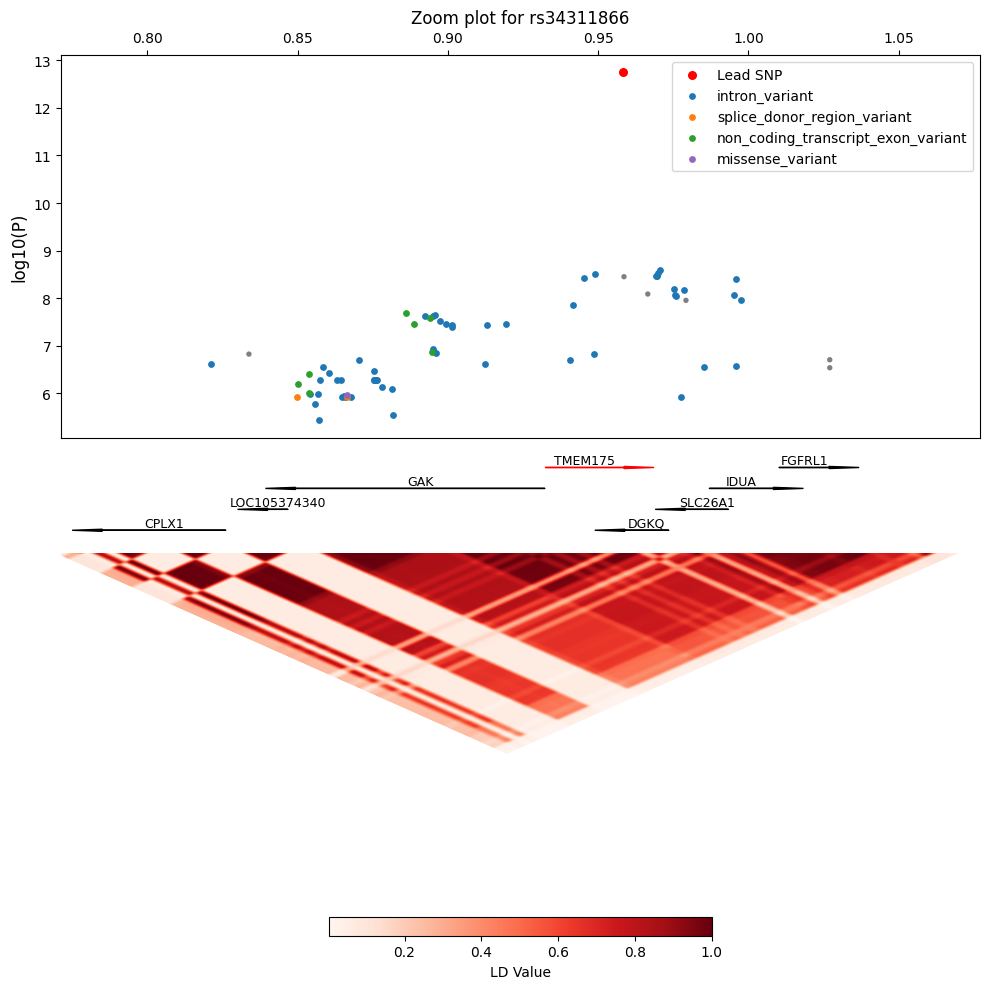

True

In [15]:
draw_zoomed_heatmap(
    data_df=df_gwas,
    lead_snp=to_highlight[2], 
    snp_col=snp_col, 
    p_col=p_col, 
    pos_col=pos_col, 
    chr_col=chr_col, 
    output_folder=path_params[0], 
    pval_threshold=5e-6, 
    radius=radius, 
    build='38', 
    gtf_path=None, 
    batch_size=100, 
    bfile_folder=path_params[3], 
    bfile_name=path_params[4], 
    effect_dict={}    
)

2024/12/16 15:38:32 Start to annotate variants with nearest gene name(s)...
2024/12/16 15:38:32  -Assigning Gene name using NCBI refseq latest GRCh38 for protein coding genes
2024/12/16 15:38:32  -Using user-provided gtf:/home/luis/CGE/ideal-genom/GCF_000001405.40_GRCh38.p14_genomic.gtf
2024/12/16 15:38:34 Finished annotating variants with nearest gene name(s) successfully!


               Functional_Consequence  count
0                      intron_variant    340
1  non_coding_transcript_exon_variant     15
2                 3_prime_UTR_variant      4
3                 5_prime_UTR_variant      4
4         splice_donor_region_variant      1
5               splice_region_variant      1
6                  intergenic_variant      1




LOC124900855 89.538208 89.551324 0.013115999999996575
LOC105377329 89.55139 89.645446 0.09405600000000902
LOC124900602 89.681505 89.726132 0.04462700000000552
SNCA 89.724099 89.838304 0.11420499999999834
LOC124900856 89.738465 89.749154 0.010688999999999282

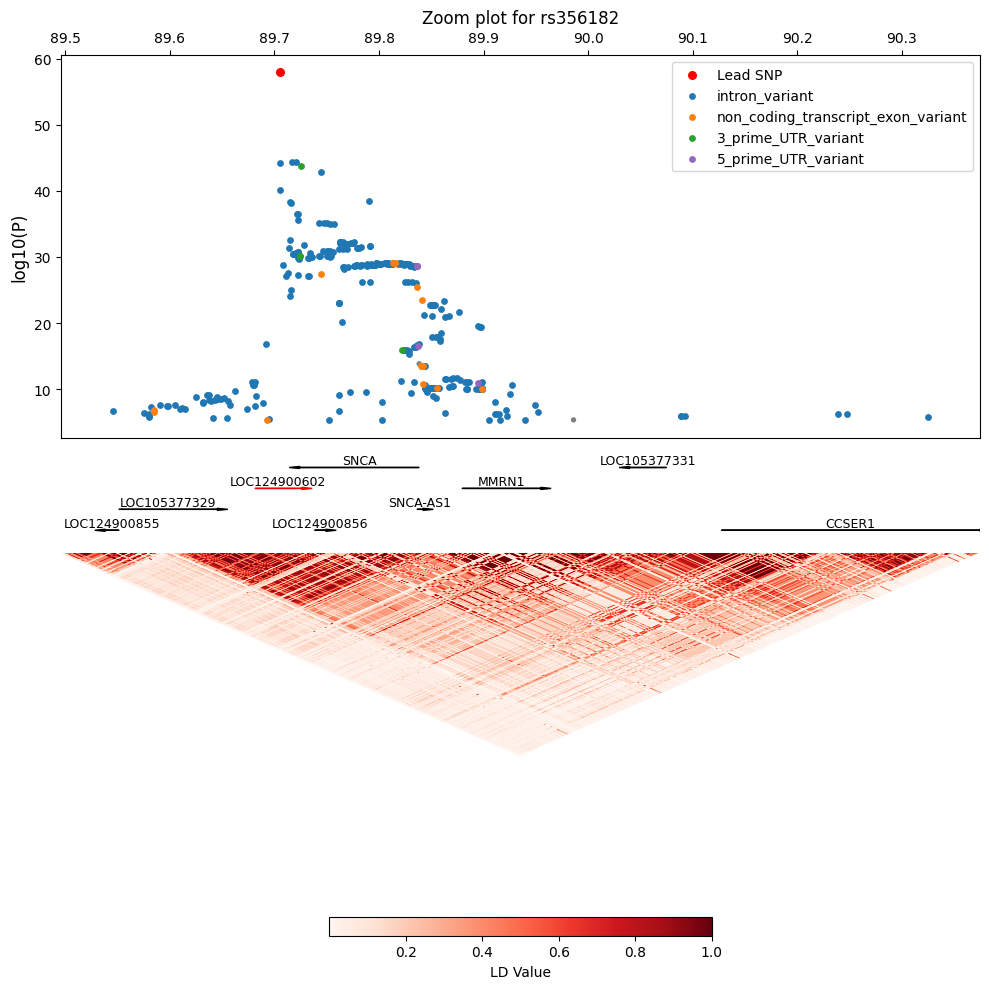

True

In [13]:
draw_zoomed_heatmap(
    data_df=df_gwas,
    lead_snp=to_highlight[3], 
    snp_col=snp_col, 
    p_col=p_col, 
    pos_col=pos_col, 
    chr_col=chr_col, 
    output_folder=path_params[0], 
    pval_threshold=5e-6, 
    radius=radius, 
    build='38', 
    gtf_path=None, 
    batch_size=100, 
    bfile_folder=path_params[3], 
    bfile_name=path_params[4], 
    effect_dict={}    
)

2024/12/16 15:40:04 Start to annotate variants with nearest gene name(s)...
2024/12/16 15:40:04  -Assigning Gene name using NCBI refseq latest GRCh38 for protein coding genes
2024/12/16 15:40:04  -Using user-provided gtf:/home/luis/CGE/ideal-genom/GCF_000001405.40_GRCh38.p14_genomic.gtf
2024/12/16 15:40:06 Finished annotating variants with nearest gene name(s) successfully!


               Functional_Consequence  count
0                      intron_variant    340
1  non_coding_transcript_exon_variant     15
2                 3_prime_UTR_variant      4
3                 5_prime_UTR_variant      4
4         splice_donor_region_variant      1
5               splice_region_variant      1
6                  intergenic_variant      1




LOC124900855 89.538208 89.551324 0.013115999999996575
LOC105377329 89.55139 89.645446 0.09405600000000902
LOC124900602 89.681505 89.726132 0.04462700000000552
SNCA 89.724099 89.838304 0.11420499999999834
LOC124900856 89.738465 89.749154 0.010688999999999282

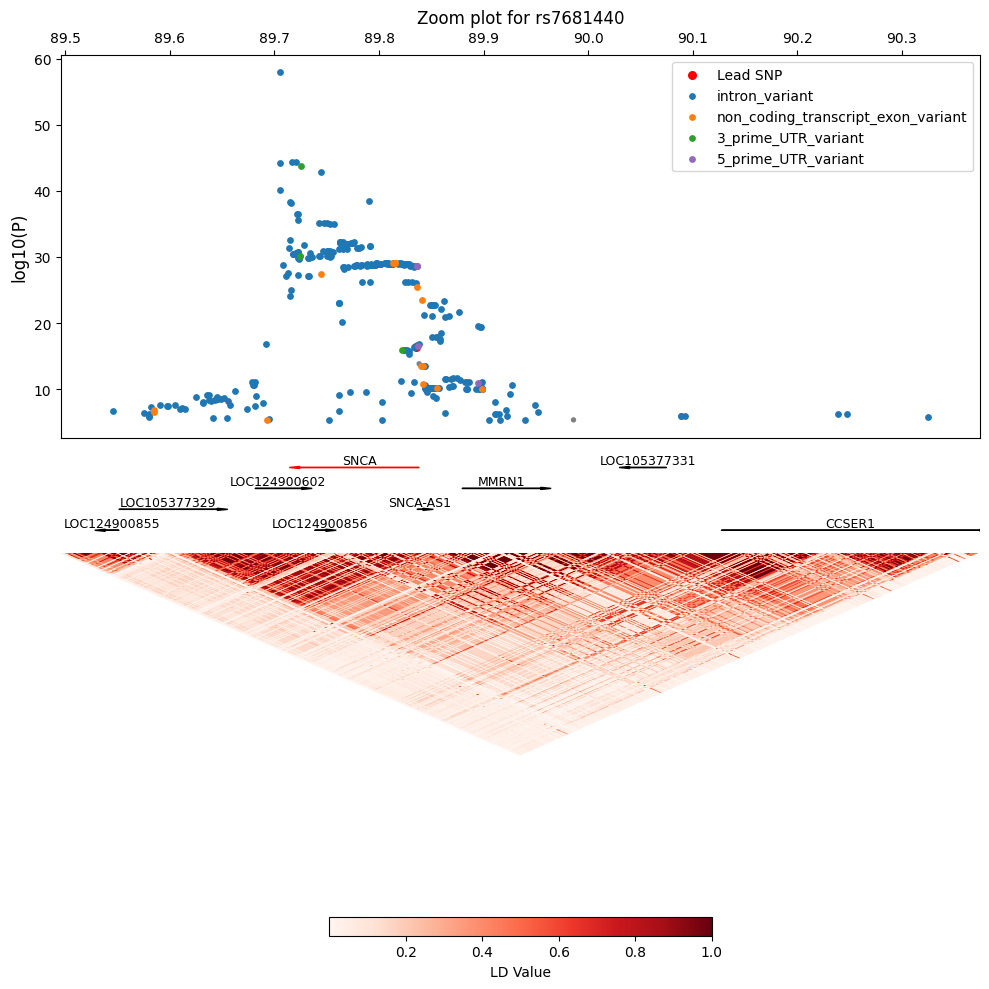

True

In [14]:
draw_zoomed_heatmap(
    data_df=df_gwas,
    lead_snp=to_highlight[4], 
    snp_col=snp_col, 
    p_col=p_col, 
    pos_col=pos_col, 
    chr_col=chr_col, 
    output_folder=path_params[0], 
    pval_threshold=5e-6, 
    radius=radius, 
    build='38', 
    gtf_path=None, 
    batch_size=100, 
    bfile_folder=path_params[3], 
    bfile_name=path_params[4], 
    effect_dict={}    
)

2024/12/16 16:05:21 Start to annotate variants with nearest gene name(s)...
2024/12/16 16:05:21  -Assigning Gene name using NCBI refseq latest GRCh38 for protein coding genes
2024/12/16 16:05:21  -Using user-provided gtf:/home/luis/CGE/ideal-genom/GCF_000001405.40_GRCh38.p14_genomic.gtf
2024/12/16 16:05:21 Finished annotating variants with nearest gene name(s) successfully!


               Functional_Consequence  count
0                      intron_variant     11
1  non_coding_transcript_exon_variant      4
2               upstream_gene_variant      2
3                 3_prime_UTR_variant      2




MIR4485 10.50827 10.508326 5.600000000072214e-05
RNF141 10.511673 10.541187 0.029514000000000706


PLINK v1.90b7.4 64-bit (18 Aug 2024)           www.cog-genomics.org/plink/1.9/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/luis/data/gwasResult/matrix-ld.log.
Options in effect:
  --bfile /home/luis/data/LuxGiantimputed/inputData/luxgiant_im

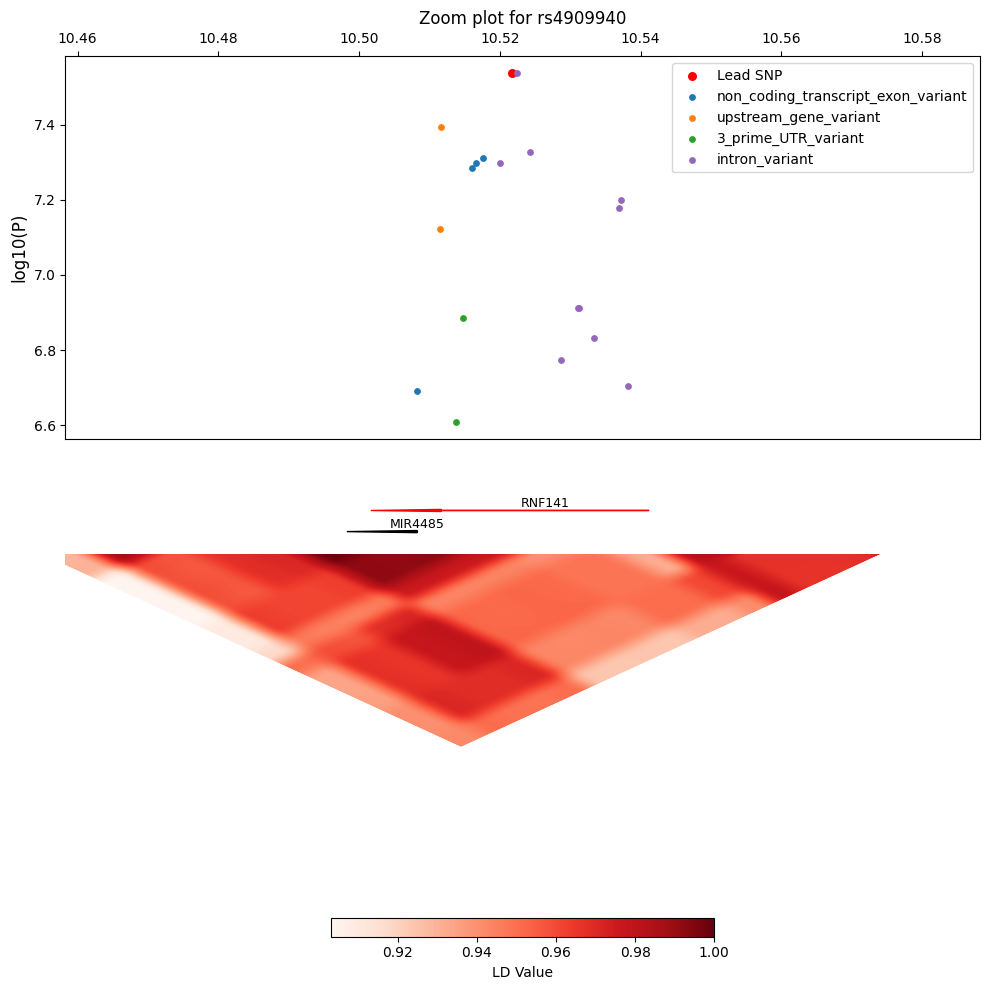

True

In [15]:
draw_zoomed_heatmap(
    data_df=df_gwas,
    lead_snp=to_highlight[7], 
    snp_col=snp_col, 
    p_col=p_col, 
    pos_col=pos_col, 
    chr_col=chr_col, 
    output_folder=path_params[0], 
    pval_threshold=5e-6, 
    radius=radius, 
    build='38', 
    gtf_path=None, 
    batch_size=100, 
    bfile_folder=path_params[3], 
    bfile_name=path_params[4], 
    effect_dict={}    
)

2024/12/16 16:05:52 Start to annotate variants with nearest gene name(s)...
2024/12/16 16:05:52  -Assigning Gene name using NCBI refseq latest GRCh38 for protein coding genes
2024/12/16 16:05:52  -Using user-provided gtf:/home/luis/CGE/ideal-genom/GCF_000001405.40_GRCh38.p14_genomic.gtf
2024/12/16 16:05:52 Finished annotating variants with nearest gene name(s) successfully!


  Functional_Consequence  count
0  upstream_gene_variant      2
1     intergenic_variant      2




LOC124903448 25.636452 25.641767 0.005315000000003067
ATP10A 25.672237 25.712486000000002 0.040249000000002866


PLINK v1.90b7.4 64-bit (18 Aug 2024)           www.cog-genomics.org/plink/1.9/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/luis/data/gwasResult/matrix-ld.log.
Options in effect:
  --bfile /home/luis/data/LuxGiantimputed/inputData/luxgiant_imputed_noprobID
  --extract /home/luis/data/LuxGiantimputed/inputData/luxgiant_imputed_noprobID-snplist.txt
  --out 

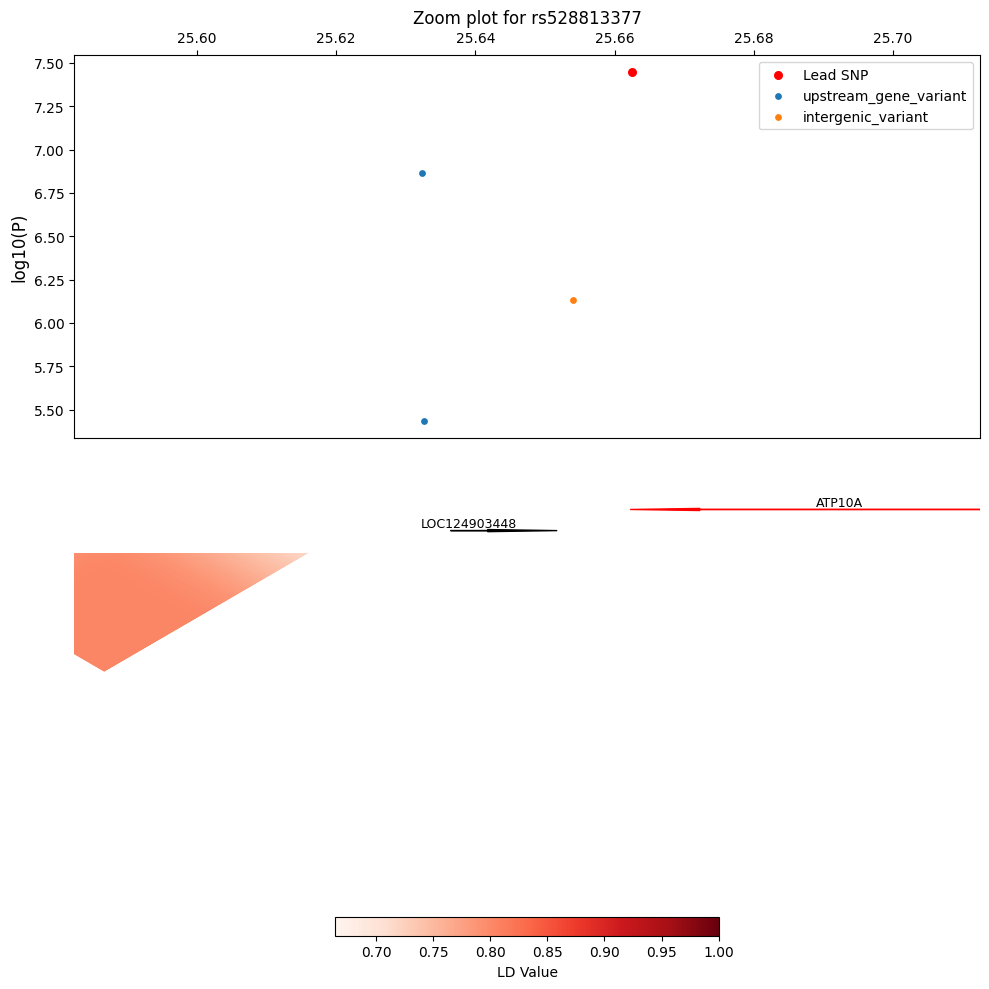

True

In [16]:
draw_zoomed_heatmap(
    data_df=df_gwas,
    lead_snp=to_highlight[8], 
    snp_col=snp_col, 
    p_col=p_col, 
    pos_col=pos_col, 
    chr_col=chr_col, 
    output_folder=path_params[0], 
    pval_threshold=5e-6, 
    radius=radius, 
    build='38', 
    gtf_path=None, 
    batch_size=100, 
    bfile_folder=path_params[3], 
    bfile_name=path_params[4], 
    effect_dict={}    
)

In [17]:
draw_zoomed_heatmap(
    data_df=df_gwas,
    lead_snp=to_highlight[9], 
    snp_col=snp_col, 
    p_col=p_col, 
    pos_col=pos_col, 
    chr_col=chr_col, 
    output_folder=path_params[0], 
    pval_threshold=5e-6, 
    radius=radius, 
    build='38', 
    gtf_path=None, 
    batch_size=100, 
    bfile_folder=path_params[3], 
    bfile_name=path_params[4], 
    effect_dict={}    
)

2024/12/16 16:06:32 Start to annotate variants with nearest gene name(s)...
2024/12/16 16:06:32  -Assigning Gene name using NCBI refseq latest GRCh38 for protein coding genes
2024/12/16 16:06:32  -Using user-provided gtf:/home/luis/CGE/ideal-genom/GCF_000001405.40_GRCh38.p14_genomic.gtf
2024/12/16 16:06:34 Finished annotating variants with nearest gene name(s) successfully!


ERROR:root:Request failed: HTTPSConnectionPool(host='rest.ensembl.org', port=443): Read timed out. (read timeout=10)


Failed to get response.


ERROR:root:Request failed: HTTPSConnectionPool(host='rest.ensembl.org', port=443): Read timed out. (read timeout=10)


Failed to get response.


ERROR:root:Request failed: HTTPSConnectionPool(host='rest.ensembl.org', port=443): Read timed out. (read timeout=10)


Failed to get response.


ERROR:root:Request failed: HTTPSConnectionPool(host='rest.ensembl.org', port=443): Read timed out. (read timeout=10)


Failed to get response.


ERROR:root:Request failed: HTTPSConnectionPool(host='rest.ensembl.org', port=443): Read timed out. (read timeout=10)


Failed to get response.


ERROR:root:Request failed: HTTPSConnectionPool(host='rest.ensembl.org', port=443): Read timed out. (read timeout=10)


Failed to get response.


ERROR:root:Request failed: HTTPSConnectionPool(host='rest.ensembl.org', port=443): Read timed out. (read timeout=10)


Failed to get response.


ERROR:root:Request failed: HTTPSConnectionPool(host='rest.ensembl.org', port=443): Read timed out. (read timeout=10)


Failed to get response.


ERROR:root:Request failed: HTTPSConnectionPool(host='rest.ensembl.org', port=443): Read timed out. (read timeout=10)


Failed to get response.


ERROR:root:Request failed: HTTPSConnectionPool(host='rest.ensembl.org', port=443): Read timed out. (read timeout=10)


Failed to get response.


ERROR:root:Request failed: HTTPSConnectionPool(host='rest.ensembl.org', port=443): Read timed out. (read timeout=10)


Failed to get response.


ERROR:root:Request failed: HTTPSConnectionPool(host='rest.ensembl.org', port=443): Read timed out. (read timeout=10)


Failed to get response.


ERROR:root:Request failed: HTTPSConnectionPool(host='rest.ensembl.org', port=443): Read timed out. (read timeout=10)


Failed to get response.


ERROR:root:Request failed: HTTPSConnectionPool(host='rest.ensembl.org', port=443): Read timed out. (read timeout=10)


Failed to get response.


ERROR:root:Request failed: HTTPSConnectionPool(host='rest.ensembl.org', port=443): Read timed out. (read timeout=10)


Failed to get response.


ERROR:root:Request failed: HTTPSConnectionPool(host='rest.ensembl.org', port=443): Read timed out. (read timeout=10)


Failed to get response.


ERROR:root:Request failed: HTTPSConnectionPool(host='rest.ensembl.org', port=443): Read timed out. (read timeout=10)


Failed to get response.


ERROR:root:Request failed: HTTPSConnectionPool(host='rest.ensembl.org', port=443): Read timed out. (read timeout=10)


Failed to get response.


ERROR:root:Request failed: HTTPSConnectionPool(host='rest.ensembl.org', port=443): Read timed out. (read timeout=10)


Failed to get response.


ERROR:root:Request failed: HTTPSConnectionPool(host='rest.ensembl.org', port=443): Read timed out. (read timeout=10)


Failed to get response.


ERROR:root:Request failed: HTTPSConnectionPool(host='rest.ensembl.org', port=443): Read timed out. (read timeout=10)


Failed to get response.


ERROR:root:Request failed: HTTPSConnectionPool(host='rest.ensembl.org', port=443): Read timed out. (read timeout=10)


Failed to get response.


ERROR:root:Request failed: HTTPSConnectionPool(host='rest.ensembl.org', port=443): Read timed out. (read timeout=10)


Failed to get response.


ERROR:root:Request failed: HTTPSConnectionPool(host='rest.ensembl.org', port=443): Read timed out. (read timeout=10)


Failed to get response.


ERROR:root:Request failed: HTTPSConnectionPool(host='rest.ensembl.org', port=443): Read timed out. (read timeout=10)


Failed to get response.


ERROR:root:Request failed: HTTPSConnectionPool(host='rest.ensembl.org', port=443): Read timed out. (read timeout=10)


Failed to get response.


ERROR:root:Request failed: HTTPSConnectionPool(host='rest.ensembl.org', port=443): Read timed out. (read timeout=10)


Failed to get response.


ERROR:root:Request failed: HTTPSConnectionPool(host='rest.ensembl.org', port=443): Read timed out. (read timeout=10)


Failed to get response.


KeyError: 'ID'

2024/12/16 16:15:20 Start to annotate variants with nearest gene name(s)...
2024/12/16 16:15:20  -Assigning Gene name using NCBI refseq latest GRCh38 for protein coding genes
2024/12/16 16:15:20  -Using user-provided gtf:/home/luis/CGE/ideal-genom/GCF_000001405.40_GRCh38.p14_genomic.gtf
2024/12/16 16:15:21 Finished annotating variants with nearest gene name(s) successfully!


               Functional_Consequence  count
0                      intron_variant     51
1                  intergenic_variant      7
2  non_coding_transcript_exon_variant      5
3                 3_prime_UTR_variant      1
4               upstream_gene_variant      1
5             downstream_gene_variant      1
6                  synonymous_variant      1
7           regulatory_region_variant      1




BRIP1 61.771838 61.863528 0.09168999999999983
INTS2 61.865367 61.927982 0.06261500000000098
MED13 61.942605 62.065278 0.12267299999999892
POLRMTP1 62.136923 62.140639 0.003715999999997166


PLINK v1.90b7.4 64-bit

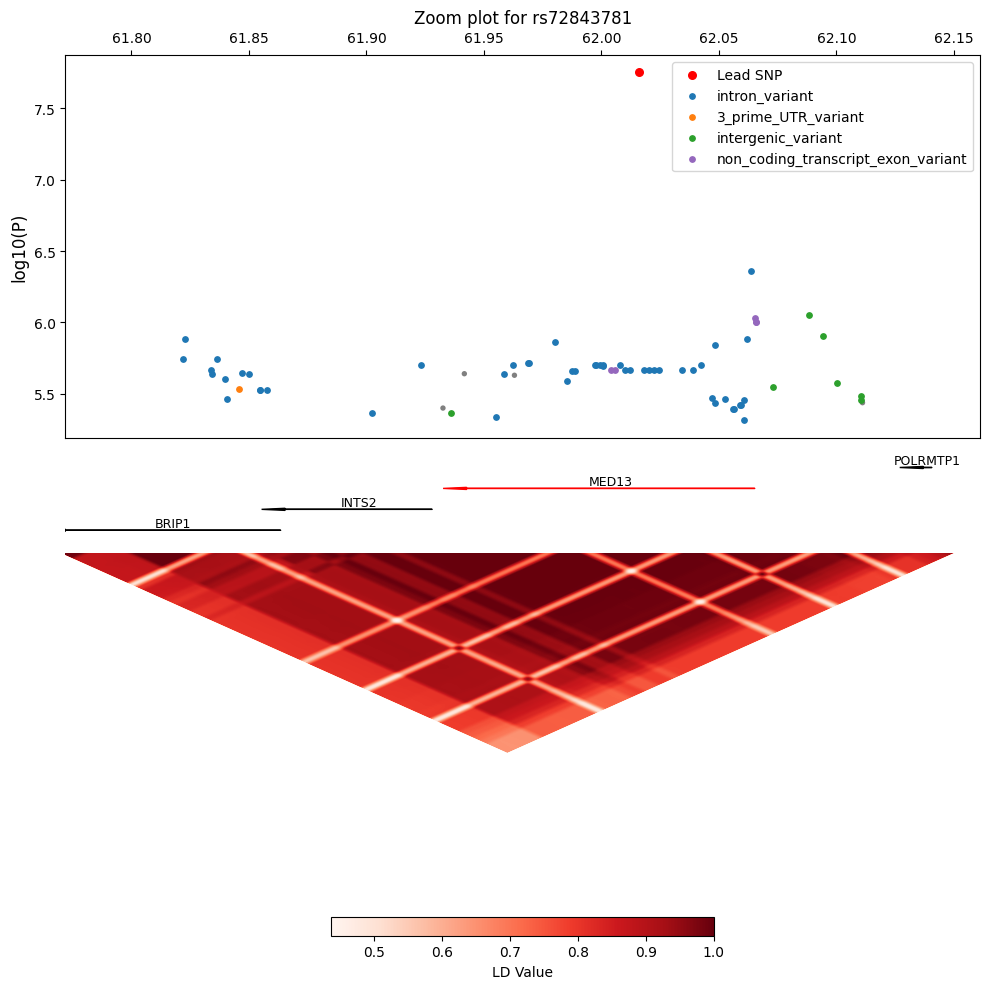

True

In [18]:
draw_zoomed_heatmap(
    data_df=df_gwas,
    lead_snp=to_highlight[10], 
    snp_col=snp_col, 
    p_col=p_col, 
    pos_col=pos_col, 
    chr_col=chr_col, 
    output_folder=path_params[0], 
    pval_threshold=5e-6, 
    radius=radius, 
    build='38', 
    gtf_path=None, 
    batch_size=100, 
    bfile_folder=path_params[3], 
    bfile_name=path_params[4], 
    effect_dict={}    
)

2024/12/16 16:15:57 Start to annotate variants with nearest gene name(s)...
2024/12/16 16:15:57  -Assigning Gene name using NCBI refseq latest GRCh38 for protein coding genes
2024/12/16 16:15:57  -Using user-provided gtf:/home/luis/CGE/ideal-genom/GCF_000001405.40_GRCh38.p14_genomic.gtf
2024/12/16 16:15:57 Finished annotating variants with nearest gene name(s) successfully!


  Functional_Consequence  count
0         intron_variant      7




RIT2 43.042999 43.115685 0.07268599999999736


PLINK v1.90b7.4 64-bit (18 Aug 2024)           www.cog-genomics.org/plink/1.9/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/luis/data/gwasResult/matrix-ld.log.
Options in effect:
  --bfile /home/luis/data/LuxGiantimputed/inputData/luxgiant_imputed_noprobID
  --extract /home/luis/data/LuxGiantimputed/inputData/luxgiant_imputed_noprobID-snplist.txt
  --out /home/luis/data/gwasResult/matrix-ld
  --r2 square

63927 MB RAM detected; reserving 31963 MB for 

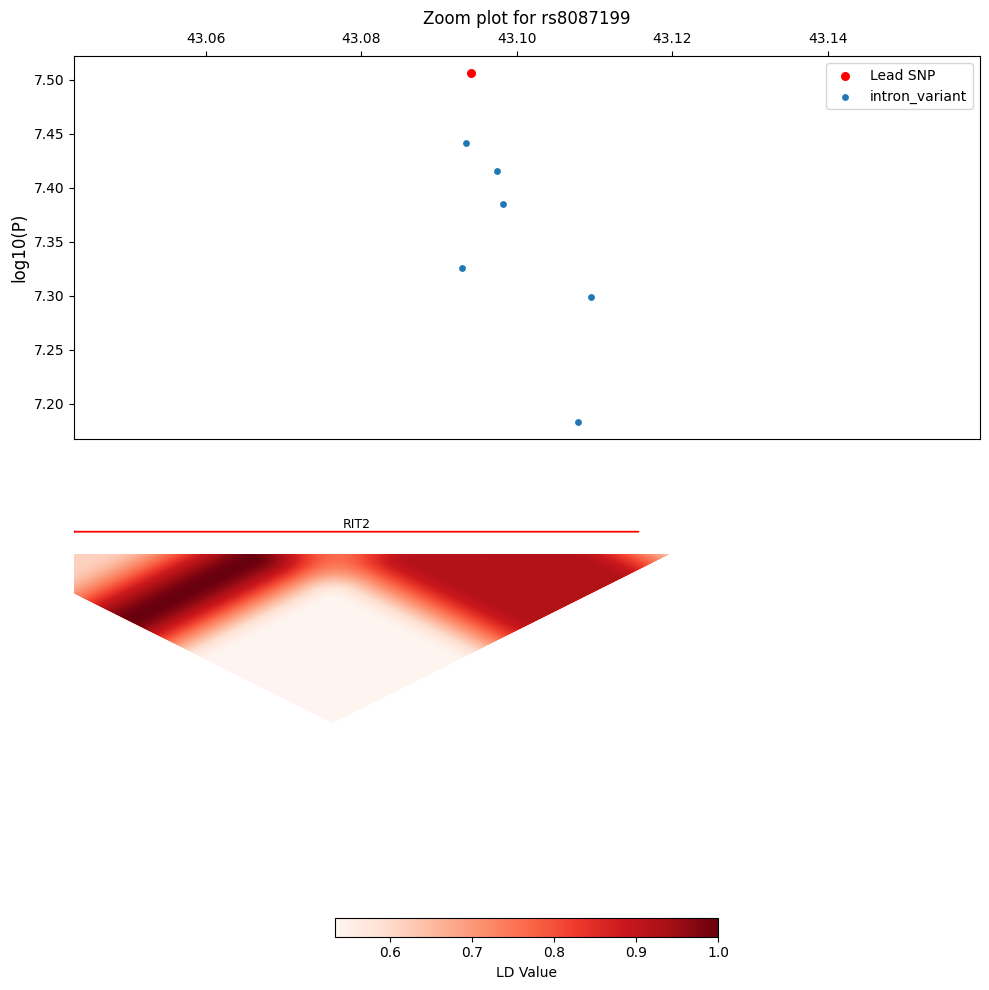

True

In [19]:
draw_zoomed_heatmap(
    data_df=df_gwas,
    lead_snp=to_highlight[11], 
    snp_col=snp_col, 
    p_col=p_col, 
    pos_col=pos_col, 
    chr_col=chr_col, 
    output_folder=path_params[0], 
    pval_threshold=5e-6, 
    radius=radius, 
    build='38', 
    gtf_path=None, 
    batch_size=100, 
    bfile_folder=path_params[3], 
    bfile_name=path_params[4], 
    effect_dict={}    
)

2024/12/16 16:16:44 Start to annotate variants with nearest gene name(s)...
2024/12/16 16:16:44  -Assigning Gene name using NCBI refseq latest GRCh38 for protein coding genes
2024/12/16 16:16:44  -Using user-provided gtf:/home/luis/CGE/ideal-genom/GCF_000001405.40_GRCh38.p14_genomic.gtf
2024/12/16 16:16:46 Finished annotating variants with nearest gene name(s) successfully!


               Functional_Consequence  count
0                      intron_variant     58
1               upstream_gene_variant     23
2                  intergenic_variant     17
3             downstream_gene_variant      9
4  non_coding_transcript_exon_variant      8
5                  synonymous_variant      2
6                    missense_variant      1
7                 3_prime_UTR_variant      1
8                 5_prime_UTR_variant      1




RBX1 40.966392000000006 40.973309 0.006916999999994289
RPS9P2 41.063996 41.064708 0.0007120000000000459
SNORD140 41.073602 41.073721 0.00011899999999798183
ACTBP15 41.

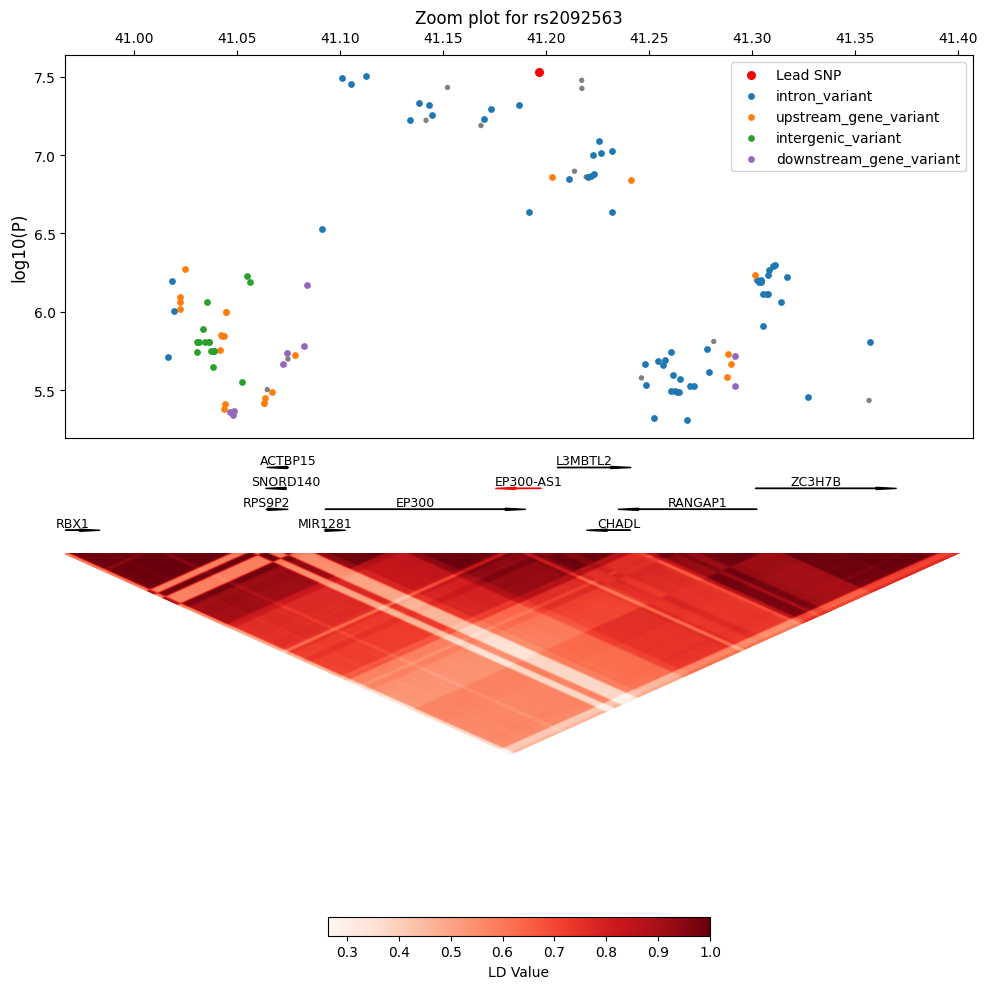

True

In [20]:
draw_zoomed_heatmap(
    data_df=df_gwas,
    lead_snp=to_highlight[12], 
    snp_col=snp_col, 
    p_col=p_col, 
    pos_col=pos_col, 
    chr_col=chr_col, 
    output_folder=path_params[0], 
    pval_threshold=5e-6, 
    radius=radius, 
    build='38', 
    gtf_path=None, 
    batch_size=100, 
    bfile_folder=path_params[3], 
    bfile_name=path_params[4], 
    effect_dict={}    
)